In [14]:
import pyrealsense2 as rs
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os

def seed_everything(num: int = 42):
    random.seed(num)
    np.random.seed(num)
    os.environ["PYTHONHASHSEED"] = str(num)

seed_everything()

## Creating Depth and Color Images

In [2]:
width = 1280
height = 720
fps = 30

In [150]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, width, height, rs.format.z16, fps)
config.enable_stream(rs.stream.color, width, height, rs.format.rgb8, fps)

In [241]:
profile = pipeline.start(config)

In [242]:
align_to = rs.stream.color
align = rs.align(align_to)

In [243]:
frames = pipeline.wait_for_frames()

In [244]:
aligned_frames = align.process(frames)

depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

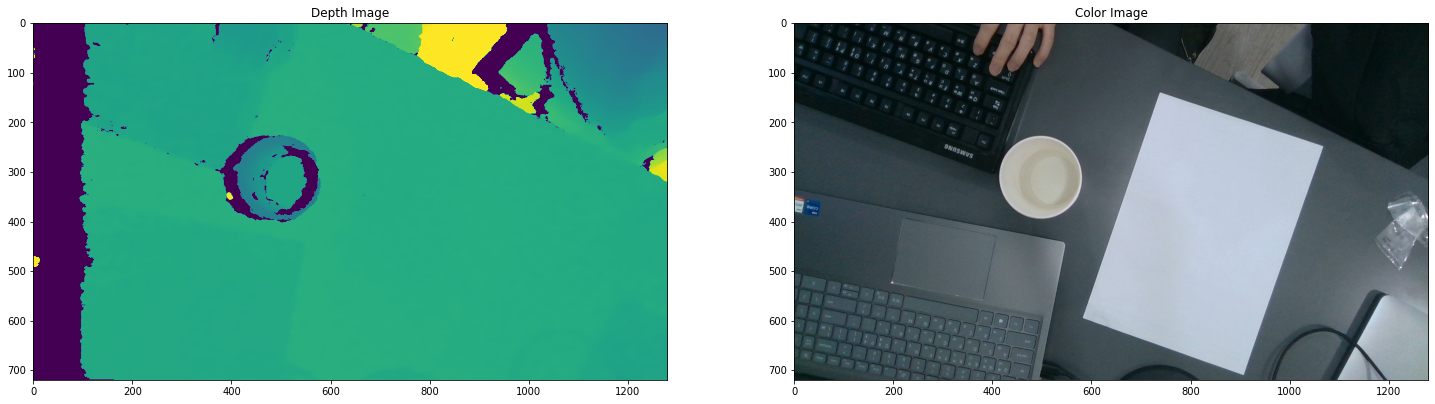

In [245]:
fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(color_image)
ax2.set_title("Color Image")

plt.show()

In [246]:
pipeline.stop()

## Filtering a Depth Image

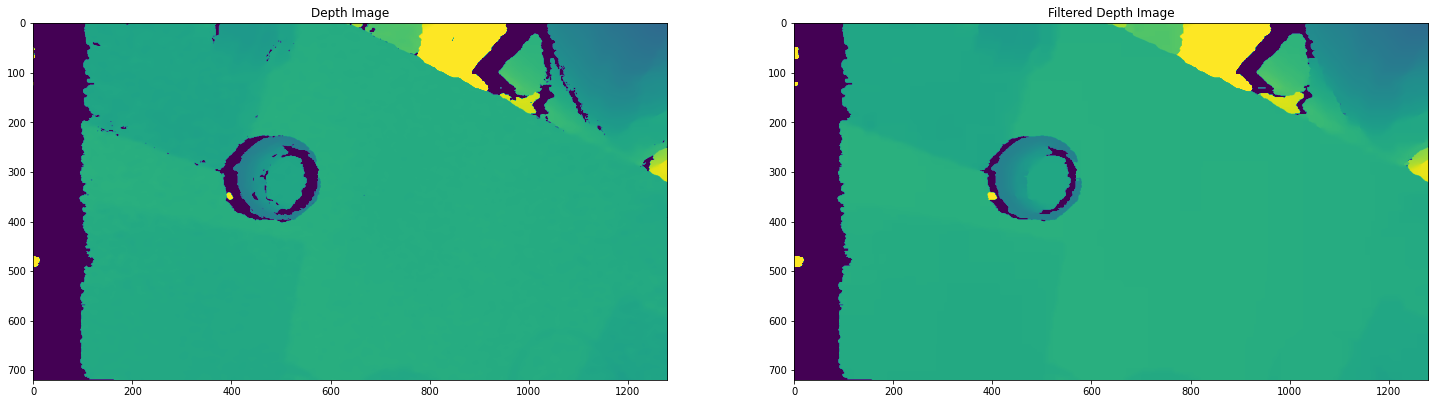

In [272]:
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 2)

filtered_depth = spatial.process(depth_frame)
filtered_depth_image = np.asanyarray(filtered_depth.get_data())

fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(filtered_depth_image, vmin=200, vmax=800)
ax2.set_title("Filtered Depth Image")

plt.show()

## Save Images

In [273]:
np.save('depth_image.npy', depth_image)
np.save('filtered_depth_image.npy', filtered_depth_image)
np.save('color_image.npy', color_image)

## Mask and Normal Vector Generation

In [3]:
def generate_mask(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,255,0),5,16)
        cv2.imshow("Mask",data["im"])
        if len(data["points"]) < 4:
            data['points'].append([x,y])

def get_normal(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,0,255),5,16)
        cv2.imshow("Normal",data["im"])
        if len(data["points"]) < 3:
            data['points'].append([x,y])
    
def get_points(im,type):
    data = {}
    data['im'] = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2BGR)
    data['points'] = []
    
    if type == "mask":
        cv2.imshow("Mask",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Mask",generate_mask,data)
    else:
        cv2.imshow("Normal",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Normal",get_normal,data)
    cv2.waitKey(0)

    points = np.array(data['points'],dtype=float)
    return points


In [4]:
depth_image = np.load('filtered_depth_image.npy')
color_image = np.load('color_image.npy')

In [5]:
mask_points = get_points(color_image,"mask")

cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55deef45a0b0) is not the object's thread (0x55deef7915b0).
Cannot move to target thread (0x55deef45a0b0)

QObject::moveToThread: Current thread (0x55deef45a0b0) is not the object's thread (0x55deef7915b0).
Cannot move to target thread (0x55deef45a0b0)

Qt: Session management error: Could not open network socket
QObject::moveToThread: Current thread (0x55deef45a0b0) is not the object's thread (0x55deef7915b0).
Cannot move to target thread (0x55deef45a0b0)

QObject::moveToThread: Current thread (0x55deef45a0b0) is not the object's thread (0x55deef7915b0).
Cannot move to target thread (0x55deef45a0b0)

QObject::moveToThread: Current thread (0x55deef45a0b0) is not the object's thread (0x55deef7915b0).
Cannot move to target thread (0x55deef45a0b0)

QObject::moveToThread: Current thread (0x55deef45a0b0) is not the object's thread (0x55deef7915b0).
Cannot move to target thread (0x55deef45a0b0)

QObject::moveToThread: Current thread (0x55deef45a0b0) is 

In [6]:
np.save('mask_points.npy', mask_points)

mask_points

array([[ 741.,  142.],
       [ 584.,  593.],
       [ 907.,  709.],
       [1066.,  250.]])

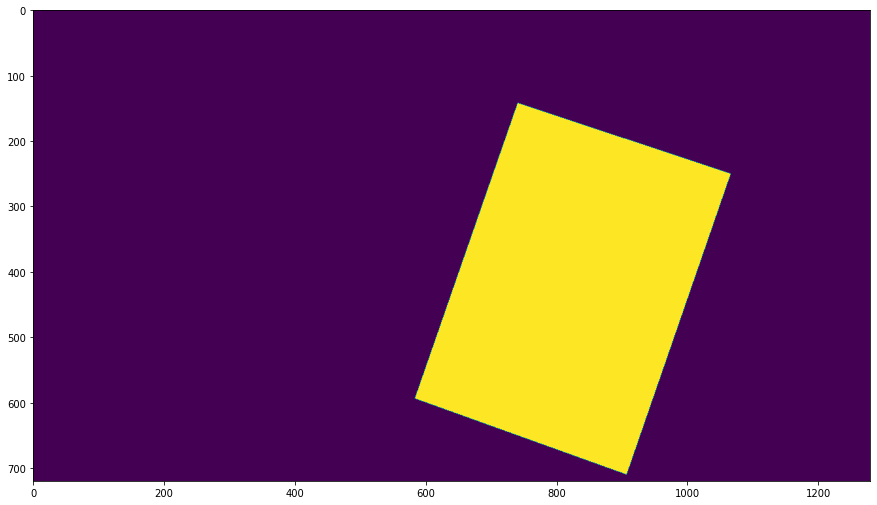

In [7]:
mask_points = np.load('mask_points.npy')

mask = np.zeros(color_image.shape[:2], dtype="uint8")

cv2.fillPoly(mask, np.int32([mask_points]), 1)
plt.figure(figsize=(15,25))
plt.imshow(mask)

In [15]:
non_index = np.nonzero(mask)
num = len(non_index[0])

normal_x = []
normal_y = []
for _ in range(100):
    random_ = np.random.choice(num, size=3, replace=False)
    normal_y.append(non_index[0][random_])
    normal_x.append(non_index[1][random_])

normal_y = np.array(normal_y)
normal_x = np.array(normal_x)

normal_x

array([[ 809,  725, 1027],
       [ 797,  933,  987],
       [ 788,  767,  680],
       [1034,  620,  695],
       [ 696,  943,  616],
       [ 932,  909,  770],
       [ 738,  838,  716],
       [ 721,  876,  699],
       [ 866,  793,  970],
       [ 761,  855,  868],
       [ 834,  652,  946],
       [ 798,  930,  783],
       [ 949,  976,  790],
       [ 978,  768,  869],
       [ 877,  807,  821],
       [ 638,  701,  870],
       [ 787,  794,  611],
       [ 921,  811,  690],
       [ 908,  705,  918],
       [ 793,  773,  856],
       [ 832,  626,  903],
       [ 746,  918,  894],
       [ 707,  874,  711],
       [ 748,  885,  917],
       [ 859,  885,  747],
       [ 798,  741,  779],
       [ 942,  686,  830],
       [ 740,  731,  895],
       [ 862,  773,  849],
       [ 738,  970,  731],
       [ 807,  811,  710],
       [ 707,  900,  785],
       [1023,  775,  666],
       [ 876,  812,  891],
       [ 948,  893,  609],
       [ 713,  653,  708],
       [ 849,  890,  774],
 

In [33]:
masked_depth = cv2.bitwise_and(depth_image,depth_image,mask=mask)

import math

deg_h = 69.4
deg_v = 42.5

px_h = masked_depth * math.tan(math.radians(deg_h/2)) / (depth_image.shape[1] / 2)
px_v = masked_depth * math.tan(math.radians(deg_v/2)) / (depth_image.shape[0] / 2)

centroid_x = np.ceil(np.sum(normal_x, axis=1) / 3)
centroid_y = np.ceil(np.sum(normal_y, axis=1) / 3)

centroid_x = centroid_x.astype(int)
centroid_y = centroid_y.astype(int)

centroid_x

array([854, 906, 745, 783, 752, 871, 764, 766, 877, 828, 811, 837, 905,
       872, 835, 737, 731, 808, 844, 808, 787, 853, 764, 850, 831, 773,
       820, 789, 828, 813, 776, 798, 822, 860, 817, 692, 838, 849, 893,
       737, 876, 766, 803, 741, 891, 868, 763, 849, 886, 707, 933, 902,
       765, 830, 769, 896, 815, 804, 749, 818, 843, 951, 818, 753, 774,
       952, 825, 781, 888, 689, 833, 854, 827, 695, 867, 874, 897, 834,
       767, 875, 815, 965, 826, 758, 768, 913, 864, 805, 834, 886, 924,
       846, 762, 812, 762, 856, 932, 877, 748, 812])

In [36]:
x_local = []
y_local = []

for k in range(len(normal_x)):
    x_center = centroid_x[k]
    y_center = centroid_y[k]
    
    sum_x = 0
    x_coor = []
    for i in range(3):
        coor = normal_x[k][i]
        if x_center <= coor:
            sum_x = np.sum(px_h[y_center,x_center:coor+1])      # TODO change to np.sum
        else:
            sum_x = np.sum(px_h[y_center,coor:x_center+1])
            sum_x = -sum_x
        x_coor.append(sum_x)
        sum_x = 0
    x_local.append(x_coor)

    sum_y = 0
    y_coor = []
    for i in range(3):
        coor = normal_y[k][i]
        if y_center <= coor:
            sum_y = np.sum(px_v[y_center:coor+1,x_center])
            sum_y = -sum_y
        else:
            sum_y = np.sum(px_v[coor:y_center+1,x_center])
        y_coor.append(sum_y)
        sum_y = 0
    y_local.append(y_coor)

x_local = np.array(x_local)
y_local = np.array(y_local)

x_local

array([[ -28.60180351,  -80.82746764,  108.14610656],
       [ -68.40803571,   17.41901333,   50.97820312],
       [  27.3629979 ,   14.30847524,  -41.05910285],
       [ 131.8446201 ,  -95.24305358,  -55.36757809],
       [ -35.52180408,  119.45980981,  -85.48624226],
       [  38.59988439,   24.26652485,  -63.45497714],
       [ -16.79690571,   46.65807142,  -30.48327333],
       [ -28.61695047,   69.05394571,  -42.30331809],
       [  -7.46529143,  -52.87914761,   58.49650893],
       [ -42.30331809,   17.41901333,   25.50641238],
       [  14.93058286,  -99.5480383 ,   84.60880004],
       [ -24.88430476,   58.47811619,  -34.21591904],
       [  27.99700671,   44.77119197,  -72.1644838 ],
       [  66.53846707,  -65.32129999,   -2.48843048],
       [  26.75062762,  -18.05843177,   -9.33377814],
       [ -62.2562028 ,  -23.0179819 ,   83.36242094],
       [  35.46013428,   39.81488762,  -61.02064298],
       [  70.92026856,    2.48843048,  -74.03080666],
       [  40.43699523,  -87.

In [37]:
x_world = []
y_world = []
for k in range(len(x_local)):
    x_temp = x_local[k]
    x_true = np.array(x_temp) + centroid_x[k] - width/2

    y_temp = y_local[k]
    y_true = np.array(y_temp) + centroid_y[k] - height/2
    
    x_world.append(x_true)
    y_world.append(y_true)

x_world = np.array(x_world)
y_world = np.array(y_world)

x_world, y_world

(array([[185.39819649, 133.17253236, 322.14610656],
        [197.59196429, 283.41901333, 316.97820312],
        [132.3629979 , 119.30847524,  63.94089715],
        [274.8446201 ,  47.75694642,  87.63242191],
        [ 76.47819592, 231.45980981,  26.51375774],
        [269.59988439, 255.26652485, 167.54502286],
        [107.20309429, 170.65807142,  93.51672667],
        [ 97.38304953, 195.05394571,  83.69668191],
        [229.53470857, 184.12085239, 295.49650893],
        [145.69668191, 205.41901333, 213.50641238],
        [185.93058286,  71.4519617 , 255.60880004],
        [172.11569524, 255.47811619, 162.78408096],
        [292.99700671, 309.77119197, 192.8355162 ],
        [298.53846707, 166.67870001, 229.51156952],
        [221.75062762, 176.94156823, 185.66622186],
        [ 34.7437972 ,  73.9820181 , 180.36242094],
        [126.46013428, 130.81488762,  29.97935702],
        [238.92026856, 170.48843048,  93.96919334],
        [244.43699523, 116.88221289, 250.65807142],
        [158

In [38]:
A_xy = np.transpose(np.array([x_world[:,0],y_world[:,0]]))
B_xy = np.transpose(np.array([x_world[:,1],y_world[:,1]]))
C_xy = np.transpose(np.array([x_world[:,2],y_world[:,2]]))

A = np.concatenate((A_xy,depth_image[normal_y[:,0],normal_x[:,0]].reshape((100,1))), axis=1)
B = np.concatenate((B_xy,depth_image[normal_y[:,1],normal_x[:,1]].reshape((100,1))), axis=1)
C = np.concatenate((C_xy,depth_image[normal_y[:,2],normal_x[:,2]].reshape((100,1))), axis=1)

AB = B - A
CB = B - C

normal = np.cross(AB,CB)
norm_unit = normal / np.linalg.norm(normal, axis=1).reshape(100,1)

norm_unit

array([[-1.56432799e-02, -2.12027782e-03, -9.99875388e-01],
       [-2.06444677e-02, -2.46673966e-02, -9.99482529e-01],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
       [ 2.07077242e-03, -3.31775324e-02, -9.99447329e-01],
       [-1.04304456e-02, -9.84029233e-03, -9.99897182e-01],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+00],
       [-4.80695274e-02,  2.64975421e-02,  9.98492464e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 1.11536455e-02,  1.57479439e-02,  9.99813782e-01],
       [ 0.00000000e+00, -0.00000000e+00,  1.00000000e+00],
       [ 1.15665469e-02, -3.82294679e-02, -9.99202043e-01],
       [ 9.68718705e-03, -1.33520648e-03,  9.99952187e-01],
       [-1.81035530e-02, -1.60086193e-02, -9.99707950e-01],
       [-9.72662056e-03, -5.68752383e-03, -9.99936520e-01],
       [ 3.28105418e-02,  1.11469824e-02,  9.99399426e-01],
       [-3.64678177e-02,  1.24917092e-01,  9.91496757e-01],
       [ 2.59563687e-02,  7.96163669e-03

In [39]:
camera = np.array([0,-1])

norm_unit_x = norm_unit[:,[0,2]]
norm_unit_x = norm_unit_x / np.linalg.norm(norm_unit_x, axis=1).reshape(100,1)

norm_unit_y = norm_unit[:,[1,2]]
norm_unit_y = norm_unit_y / np.linalg.norm(norm_unit_y, axis=1).reshape(100,1)

dot_product_x = np.dot(norm_unit_x, camera)
dot_product_y = np.dot(norm_unit_y, camera)
angle_x = np.average(np.degrees(np.arccos(dot_product_x)))
angle_y = np.average(np.degrees(np.arccos(dot_product_y)))

angle_x, angle_y

(79.80523916137022, 79.26676308816575)

In [40]:
px_h_true = px_h / math.cos(angle_x)
px_v_true = px_v / math.cos(angle_y)

area = px_h_true * px_v_true
paper_area = np.sum(area)

error = np.abs(paper_area - 62370)/62370 * 100

print("Area of the paper is {:0.2f} mm^2.".format(paper_area))
print("True value is 62370 mm^2.")
print("Percent error is {:0.2f}%.".format(error))

Area of the paper is 285462.99 mm^2.
True value is 62370 mm^2.
Percent error is 357.69%.
